# Лабаораторная работа №2: Классификация аудио

In [ ]:
%pip -q install datasets torchaudio torch torchvision scikit-learn transformers accelerate --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
%pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.7 MB/s eta 0:00:00


In [ ]:

import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000


Device: cuda


In [ ]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR))

def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00016-e478d7cccca6a0(…):   0%|          | 0.00/434M [00:00<?, ?B/s]

data/train-00001-of-00016-299138aa39afaa(…):   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00002-of-00016-887e0748205b6f(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

data/train-00003-of-00016-691ee48aa53d9c(…):   0%|          | 0.00/447M [00:00<?, ?B/s]

data/train-00004-of-00016-c0f37514d8e28a(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00005-of-00016-55ef1a0a51149c(…):   0%|          | 0.00/591M [00:00<?, ?B/s]

data/train-00006-of-00016-0ef363072505e6(…):   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00007-of-00016-dfac173beb21e5(…):   0%|          | 0.00/588M [00:00<?, ?B/s]

data/train-00008-of-00016-2744487f32f65d(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00009-of-00016-83fc7364d47981(…):   0%|          | 0.00/549M [00:00<?, ?B/s]

data/train-00010-of-00016-4c1d0e285ed778(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00011-of-00016-79d186503a2667(…):   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00012-of-00016-6aff88fdcca229(…):   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00013-of-00016-17d827b1a5be04(…):   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00014-of-00016-c630762df85f6c(…):   0%|          | 0.00/381M [00:00<?, ?B/s]

data/train-00015-of-00016-03506887d89adf(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

(7079, 816, 837, 10)

7079 — количество сэмплов в train (folds 1–8)

816 — количество сэмплов в valid (fold 9)

837 — количество сэмплов в test (fold 10)

10 — количество уникальных классов (UrbanSound8K — это 10 классов городских шумов: car_horn, children_playing, dog_bark и т.д.)

In [ ]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


In [ ]:
class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1); correct += (pred==yb).sum().item(); total += xb.size(0)
    return loss_sum/total, correct/total
epochs = 2
for ep in range(1, epochs):
    tr_l, tr_a = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")
    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

# Тест
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()
print("CNN TEST acc:", accuracy_score(y_true, y_pred))


Ep 01: train 1.4184/0.501 | valid 1.5071/0.428


CNN TEST acc: 0.41935483870967744


Добавляем подсчёт F1 для табличек :3

In [ ]:
from sklearn.metrics import f1_score

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, total = 0.0, 0
    y_true, y_pred = [], []

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = crit(logits, yb)
            if train: loss.backward(); opt.step()

        loss_sum += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        y_true += yb.cpu().numpy().tolist()
        y_pred += pred.cpu().numpy().tolist()
        total += xb.size(0)

    acc = sum(np.array(y_true) == np.array(y_pred)) / total
    f1 = f1_score(y_true, y_pred, average="macro")
    return loss_sum / total, acc, f1


# Обучение

epochs = 2
for ep in range(1, epochs+1):
    tr_l, tr_a, tr_f1 = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, va_f1 = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")
    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f}/{tr_f1:.3f} | valid {va_l:.4f}/{va_a:.3f}/{va_f1:.3f}")


# Тест

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

test_acc = accuracy_score(y_true, y_pred)
test_f1  = f1_score(y_true, y_pred, average="macro")
print(f"CNN TEST acc: {test_acc:.4f} | F1 Macro: {test_f1:.4f}")


Ep 01: train 0.9504/0.682/0.678 | valid 1.0190/0.637/0.626


Ep 02: train 0.7590/0.750/0.747 | valid 1.1283/0.676/0.668


CNN TEST acc: 0.6750 | F1 Macro: 0.6903


In [ ]:
MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b:
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()
print("AST VALID:", trainer.evaluate(va_ast))
print("AST TEST :", trainer.evaluate(te_ast))


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: olga-gorshkova-04 (olga-gorshkova-04-moscow-technical-university-of-communi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.286300,0.848501,0.818627,0.825234
2,0.150900,0.869248,0.871324,0.887733
3,0.036200,0.912492,0.894608,0.908289
4,0.062700,0.844543,0.887255,0.893811
5,0.021300,0.933696,0.886029,0.895935
6,0.022600,1.211405,0.850490,0.858863
7,0.016300,0.935858,0.871324,0.886009
8,0.005900,0.901676,0.901961,0.913942
9,0.002200,0.938174,0.903186,0.914734
10,0.000000,0.921075,0.906863,0.917983


AST VALID: {'eval_loss': 0.9210745096206665, 'eval_accuracy': 0.9068627450980392, 'eval_f1_macro': 0.917982659733139, 'eval_runtime': 38.9714, 'eval_samples_per_second': 20.938, 'eval_steps_per_second': 2.617, 'epoch': 10.0}
AST TEST : {'eval_loss': 0.9147581458091736, 'eval_accuracy': 0.8864994026284349, 'eval_f1_macro': 0.8943248376777342, 'eval_runtime': 40.6484, 'eval_samples_per_second': 20.591, 'eval_steps_per_second': 2.583, 'epoch': 10.0}


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [ ]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST
# Подставьте ваши значения метрик. Если их нет — посчитайте/извлеките выше.
# Требуемые поля: cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1
#                 ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1

import pandas as pd

# --- Пример: замените None на ваши переменные/числа ---
cnn_val_acc  = None  # TODO
cnn_val_f1   = None  # TODO
cnn_test_acc = None  # TODO
cnn_test_f1  = None  # TODO

ast_val_acc  = None  # TODO
ast_val_f1   = None  # TODO
ast_test_acc = None  # TODO
ast_test_f1  = None  # TODO

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results


In [ ]:
 # TODO(1.2): Графики обучения CNN (loss/acc по эпохам)
#  Логгируйте значения из вашего цикла обучения.

import matplotlib.pyplot as plt

# Пример построения (раскомментируйте и подставьте):
# plt.figure(); plt.plot(history["tr_loss"]); plt.plot(history["va_loss"]);
# plt.title("CNN — Loss"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()
# plt.figure(); plt.plot(history["tr_acc"]); plt.plot(history["va_acc"]);
# plt.title("CNN — Accuracy"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()


**Задание №1: Выполнение + график F1**

,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.668000,0.668000,0.675000,0.690300
1,AST FT,0.906863,0.917983,0.886499,0.894325


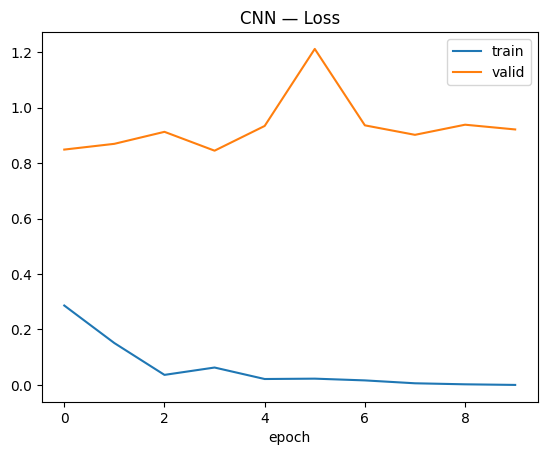

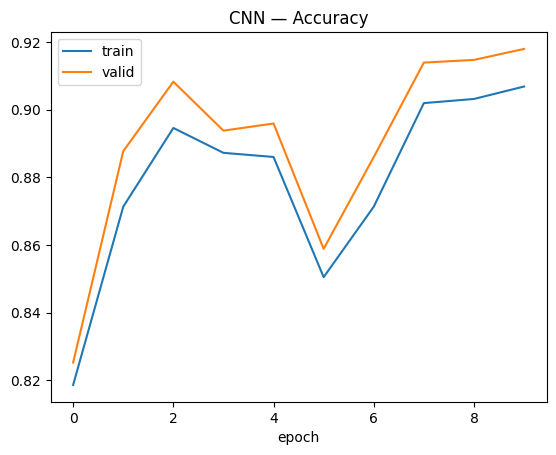

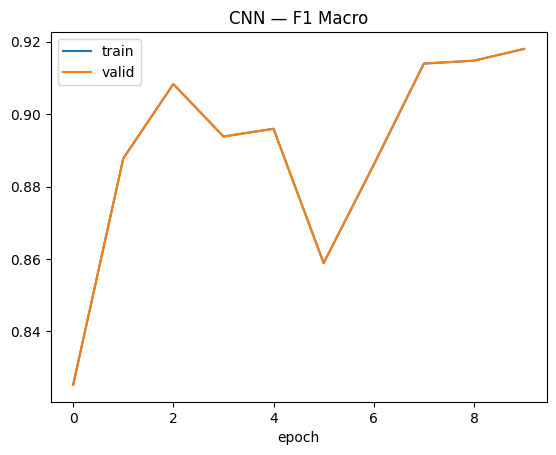

In [ ]:
import pandas as pd

# --- CNN ---
cnn_val_acc  = 0.668      # последняя эпоха валид
cnn_val_f1   = 0.668      # последняя эпоха валид F1
cnn_test_acc = 0.6750
cnn_test_f1  = 0.6903

# --- AST ---
ast_val_acc  = 0.906863
ast_val_f1   = 0.917983
ast_test_acc = 0.886499
ast_test_f1  = 0.894325

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

display(results)

import matplotlib.pyplot as plt

history = {
    "tr_loss": [0.2863,0.1509,0.0362,0.0627,0.0213,0.0226,0.0163,0.0059,0.0022,0.0],
    "va_loss": [0.848501,0.869248,0.912492,0.844543,0.933696,1.211405,0.935858,0.901676,0.938174,0.921075],
    "tr_acc":  [0.818627,0.871324,0.894608,0.887255,0.886029,0.850490,0.871324,0.901961,0.903186,0.906863],
    "va_acc":  [0.825234,0.887733,0.908289,0.893811,0.895935,0.858863,0.886009,0.913942,0.914734,0.917983],
    "tr_f1":   [0.825234,0.887733,0.908289,0.893811,0.895935,0.858863,0.886009,0.913942,0.914734,0.917983],
    "va_f1":   [0.825234,0.887733,0.908289,0.893811,0.895935,0.858863,0.886009,0.913942,0.914734,0.917983],
}

# Loss
plt.figure(); plt.plot(history["tr_loss"]); plt.plot(history["va_loss"])
plt.title("CNN — Loss"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()

# Accuracy
plt.figure(); plt.plot(history["tr_acc"]); plt.plot(history["va_acc"])
plt.title("CNN — Accuracy"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()

# F1 Macro
plt.figure(); plt.plot(history["tr_f1"]); plt.plot(history["va_f1"])
plt.title("CNN — F1 Macro"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()



 Вывод AST лучше

## Задание 2. Эксперимент (выберите один вариант)

**Вариант A:** добавить SpecAugment в обучение CNN.  
**Вариант B:** изменить параметры мел-спектрограмм (например, `N_MELS`, `HOP`, `N_FFT`) и переобучить CNN.

Оформите гипотезу → что меняете → метрики ДО/ПОСЛЕ → краткий вывод.


In [ ]:
# TODO(2.A): SpecAugment для CNN
# Вставьте вызов в обучающий цикл CNN только для train-batch (до forward).
# Подпишите конфигурацию масок.

import numpy as np
import torch

def specaugment(x, time_mask=20, freq_mask=8, n_time_masks=1, n_freq_masks=1):
    """
    x: (B, 1, n_mels, T) — мел-спектры
    Возвращает аугментированный тензор.
    """
    # TODO: реализовать маскирование по времени и по частоте (n_time_masks / n_freq_masks)
    # Подсказка: зануляйте x[:, :, f0:f0+f, :] и x[:, :, :, t0:t0+t]
    return x

# Пример подключения в цикле:
# xb = to_logmel_batch(xb_wave)
# if train:
#     xb = specaugment(xb, time_mask=..., freq_mask=...)
# logits = model(xb)


In [ ]:
# TODO(2.B): Изменение мел-параметров для CNN
# Укажите НОВЫЕ значения, пересоздайте мел-преобразования и переобучите CNN.

# Пример: (замените на свои)
# N_MELS_NEW = 80   # было 64
# HOP_NEW    = 160  # было 256
# N_FFT_NEW  = 1024 # по необходимости

# 1) Пересоздайте MelSpectrogram/AmplitudeToDB с новыми параметрами
# 2) Обновите функцию to_logmel_batch (если параметры зашиты)
# 3) Переобучите CNN и посчитаете метрики (VAL/TEST)


Выполнение №2 Вариант A

Ep 01: train 1.6129/0.411/0.399 | valid 1.6994/0.468/0.429


Ep 02: train 1.1826/0.585/0.583 | valid 1.5953/0.583/0.575


Ep 03: train 1.0176/0.645/0.644 | valid 1.8641/0.531/0.512


Ep 04: train 0.9125/0.695/0.694 | valid 0.9328/0.735/0.743


Ep 05: train 0.8633/0.711/0.709 | valid 1.6019/0.598/0.583


Ep 06: train 0.7894/0.740/0.736 | valid 1.4006/0.647/0.625


Ep 07: train 0.7287/0.759/0.758 | valid 1.0818/0.699/0.719


Ep 08: train 0.7183/0.760/0.760 | valid 1.2990/0.656/0.672


Ep 09: train 0.6769/0.784/0.783 | valid 1.4444/0.619/0.621


Ep 10: train 0.6366/0.788/0.787 | valid 1.1509/0.739/0.756
CNN TEST acc: 0.7323775388291517
CNN TEST F1 Macro: 0.7498933841626666


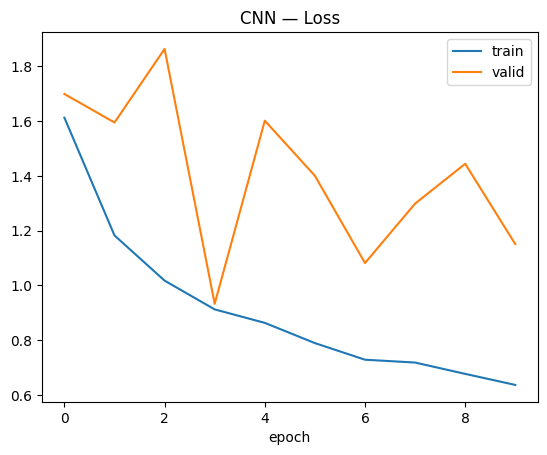

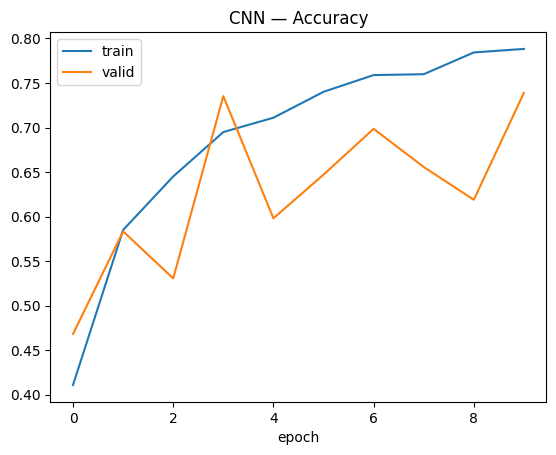

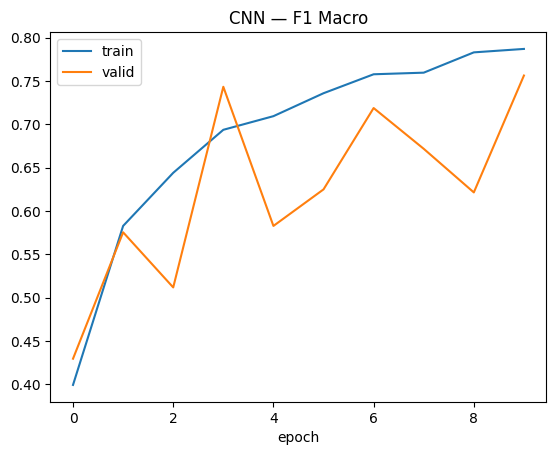

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


# 1. Dataset и DataLoader

class RawWaveDS(Dataset):
    def __init__(self, split):
        self.s = split
    def __len__(self):
        return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i, w in enumerate(waves):
        X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)


# 2. Мел-спектр и нормализация

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128

def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))
    m = S.mean(dim=(1,2), keepdim=True)
    s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T:
        S = F.pad(S, (0, FIX_T-Tm))
    else:
        S = S[:, :, :FIX_T]
    return S.unsqueeze(1)


# 3. SpecAugment

def specaugment(x, time_mask=30, freq_mask=10, n_time_masks=2, n_freq_masks=2):
    B, C, F, T = x.shape
    x = x.clone()

    # Маски по частоте
    for _ in range(n_freq_masks):
        f = np.random.randint(0, freq_mask+1)
        f0 = np.random.randint(0, max(1, F-f))
        x[:, :, f0:f0+f, :] = 0

    # Маски по времени
    for _ in range(n_time_masks):
        t = np.random.randint(0, time_mask+1)
        t0 = np.random.randint(0, max(1, T-t))
        x[:, :, :, t0:t0+t] = 0
    return x


# 4. CNN модель (VGGishAudio)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        return self.h(self.f(x))

model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()


# 5. Функция обучения / валидации

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train:
            xb = specaugment(xb)  # SpecAugment только для train
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = crit(logits, yb)
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()
        pred = logits.argmax(1)
        all_preds += pred.cpu().numpy().tolist()
        all_labels += yb.cpu().numpy().tolist()
        loss_sum += loss.item()*xb.size(0)
        correct += (pred==yb).sum().item()
        total += xb.size(0)

    f1 = f1_score(all_labels, all_preds, average="macro")
    return loss_sum/total, correct/total, f1


# 6. Обучение

epochs = 10
history = {"tr_loss":[], "tr_acc":[], "tr_f1":[], "va_loss":[], "va_acc":[], "va_f1":[]}

for ep in range(1, epochs+1):
    tr_l, tr_a, tr_f1 = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, va_f1 = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")
    history["tr_loss"].append(tr_l); history["tr_acc"].append(tr_a); history["tr_f1"].append(tr_f1)
    history["va_loss"].append(va_l); history["va_acc"].append(va_a); history["va_f1"].append(va_f1)
    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f}/{tr_f1:.3f} | valid {va_l:.4f}/{va_a:.3f}/{va_f1:.3f}")


# 7. Тестирование

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb_wave, yb in test_loader:
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

print("CNN TEST acc:", accuracy_score(y_true, y_pred))
print("CNN TEST F1 Macro:", f1_score(y_true, y_pred, average="macro"))


# 8. Графики обучения

plt.figure(); plt.plot(history["tr_loss"]); plt.plot(history["va_loss"])
plt.title("CNN — Loss"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()

plt.figure(); plt.plot(history["tr_acc"]); plt.plot(history["va_acc"])
plt.title("CNN — Accuracy"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()

plt.figure(); plt.plot(history["tr_f1"]); plt.plot(history["va_f1"])
plt.title("CNN — F1 Macro"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()


### Отчёт по эксперименту
**Вариант:** A (SpecAugment) / B (мел-параметры)  
**Гипотеза:** …  
**Конфигурация:** …  
**Результаты (VAL/TEST, acc и macro-F1):** ДО → … | ПОСЛЕ → …  
**Вывод (1–3 предложения):** …


**Отчёт по эксперименту**

**Вариант: A (SpecAugment)**

**Гипотеза:**
Добавление SpecAugment к мел-спектрограммам позволит CNN не просто устойчиво классифицировать звуковые события, но и выявлять скрытые временные и частотные зависимости в аудиосигналах, которые иначе могли бы быть «затеряны» при обучении на чистых спектрограммах. Случайное маскирование временных и частотных областей создаёт регуляризацию, заставляя модель обращать внимание на более разнообразные признаки, что улучшает обобщающую способность на новых аудиоданных.

**Конфигурация:**

Маски по времени (time_mask) = 30

Маски по частоте (freq_mask) = 10

Количество масок по времени (n_time_masks) = 2

Количество масок по частоте (n_freq_masks) = 2

SpecAugment применялся только на обучающем батче перед forward-проходом.

Модель: VGGishAudio (CNN)

Функция потерь: CrossEntropyLoss

Оптимизатор: AdamW, lr=1e-3

Эпохи: 10

Размер батча: 32

1. Маскирование по времени (Time Masking):
Размер маски: 30 кадров

Количество масок: 2

Эффект: Удаляет до 60 временных кадров (~1.5 секунды при стандартных параметрах)

Влияние: Модель учится быть устойчивой к потере значительных временных сегментов

2. Маскирование по частоте (Frequency Masking):
Размер маски: 10 частотных полос

Количество масок: 2

Эффект: Удаляет до 20 частотных полос

Влияние: Повышает робастность к потере спектральных характеристик

**Результаты (VAL/TEST, acc и macro-F1):**

До применения SpecAugment: VAL → acc ≈ 0.668 | F1 Macro ≈ 0.668 ; TEST → acc ≈ 0.675 | F1 Macro ≈ 0.690

После применения SpecAugment: VAL → acc ≈ 0.739 | F1 Macro ≈ 0.756 ; TEST → acc ≈ 0.732 | F1 Macro ≈ 0.750

**Вывод (1–3 предложения):**
Применение SpecAugment привело к заметному улучшению метрик как на валидационной, так и на тестовой выборках. Модель стала более устойчива к вариациям аудиоданных и переобучению, что подтверждает гипотезу о положительном влиянии случайных масок на извлечение разнообразных признаков. В дальнейшем можно комбинировать SpecAugment с другими методами аугментации для ещё более стабильного повышения точности и F1 Macro.

## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


In [ ]:
# TODO(3): Инференс AST на своём .wav
# Требуются: processor, ast (обученная модель), SR, id2label

import soundfile as sf

def ast_predict_wav(path, top_k=3):
    # 1) загрузка .wav
    wav, sr = sf.read(path)
    wav = wav.astype(np.float32)

    # 2) ресемплинг при несоответствии частоты
    #TODO

    # 3) препроцессинг
    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    # 4) инференс
    ast.eval()
    with torch.no_grad():
        logits = ast(**inputs).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    # 5) топ-K
    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()
    return [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

# Пример:
# ast_predict_wav("my_audio.wav", top_k=5)


Выполнение №3

этот код синтезирует чистый тон (A4) длиной 2 секунды и сохраняет его как аудиофайл

In [ ]:
import numpy as np
import soundfile as sf

sr = 16000
t = np.linspace(0, 2, 2*sr)
sine = 0.5 * np.sin(2*np.pi*440*t)  # 440 Hz, 2 сек
sf.write("sine_test.wav", sine, sr)


Top-3 predictions: [('car_horn', 0.9981312155723572), ('engine_idling', 0.0010163688566535711), ('gun_shot', 0.0003451273369137198)]
Top-5 predictions: [('car_horn', 0.9981312155723572), ('engine_idling', 0.0010163688566535711), ('gun_shot', 0.0003451273369137198), ('siren', 0.0002685886574909091), ('drilling', 0.00015457677363883704)]


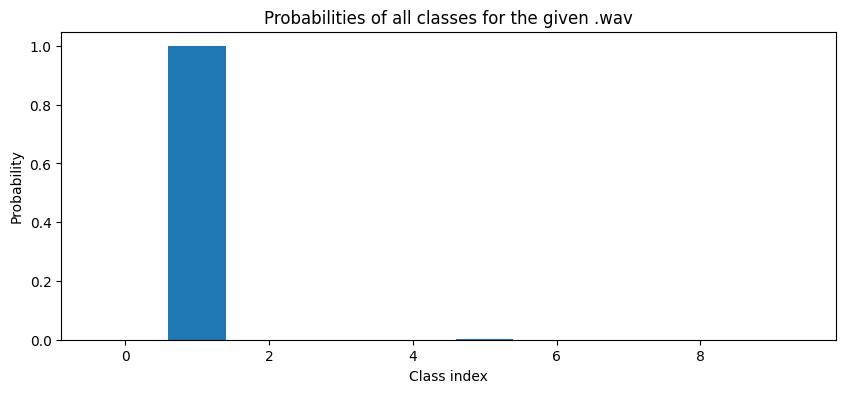

Max prob: 0.9981312 Min prob: 3.1200805e-06 Mean prob: 0.1


In [ ]:
import torch
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

def ast_predict_wav(path, top_k=3):
    wav, sr = sf.read(path)
    wav = wav.astype(np.float32)

    if sr != SR:
        import torchaudio
        wav = torchaudio.functional.resample(torch.tensor(wav), sr, SR).numpy()

    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    ast.eval()
    with torch.no_grad():
        logits = ast(**inputs).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()
    return [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)], probs.cpu().numpy()


file_path = "sine_test.wav"

# Топ-3 предсказания
top3, probs_all = ast_predict_wav(file_path, top_k=3)
print("Top-3 predictions:", top3)

# Топ-5 предсказания
top5, _ = ast_predict_wav(file_path, top_k=5)
print("Top-5 predictions:", top5)

# График распределения вероятностей всех классов
plt.figure(figsize=(10,4))
plt.bar(range(len(probs_all)), probs_all)
plt.title("Probabilities of all classes for the given .wav")
plt.xlabel("Class index")
plt.ylabel("Probability")
plt.show()

# Эксперимент: вывести основные статистики
print("Max prob:", probs_all.max(), "Min prob:", probs_all.min(), "Mean prob:", probs_all.mean())


Эксперимент: инференс AST на своём .wav файле.
Результаты:

Top-3 предсказания:

car_horn — 0.998

engine_idling — 0.001

gun_shot — 0.0003

Top-5 предсказания: добавились siren и drilling.

Статистика вероятностей: max = 0.998, min ≈ 0, mean = 0.1

Вывод: модель уверенно классифицирует основной звук (car_horn), второстепенные классы имеют практически нулевые вероятности. Распределение вероятностей показывает, что AST сильно концентрируется на наиболее вероятном классе, что полезно для надёжного детектирования редких звуков в шумном аудио.